# Life-Cycle Labor Supply of Couples

Solves and simulates a $T$-period labor supply model with two-earner couples. <br>
**Motivated** by the study “Are Marriage-Related Taxes and Social Security Benefits Holding Back Female Labor Supply?” by Borella et al. (forthcoming). <br>
**Goal** is to replicate effects of individual vs. joint taxation.

For simplicity, couples cannot divorce nor save.

The **Bellman equation** and the recursive formulation of our simple model is 
$$
\begin{align*}
V_{t}(K_{1,t},K_{2,t}) & =\max_{h_{1,t},h_{2,t}}U(c_{t},h_{1,t},h_{2,t})+\beta V_{t+1}(K_{1,t+1},K_{2,t+1})\\
c_{t} & =\sum_{j=1}^{2}w_{j,t}h_{j,t}-T(w_{1,t}h_{1,t},w_{2,t}h_{2,t})\\
\log w_{j,t} & =\alpha_{j,0}+\alpha_{j,1}K_{j,t},\;j\in\{1,2\}\\
K_{j,t+1} & =(1-\delta)K_{j,t}+h_{j,t},\;j\in\{1,2\}
\end{align*}
$$

**Preferences** are sum of individuals
$$
U(c_{t},h_{1,t},h_{2,t})=2\frac{(c_{t}/2)^{1+\eta}}{1+\eta}-\rho_{1}\frac{h_{1,t}^{1+\gamma}}{1+\gamma}-\rho_{2}\frac{h_{2,t}^{1+\gamma}}{1+\gamma}
$$

**Taxes** are on the household level
$$
T(Y_{1},Y_{2})=(1-\lambda(Y_{1}+Y_{2})^{-\tau})\cdot(Y_{1}+Y_{2})
$$

**Terminal period:** There are no bequests such that
$$
V_{T}(K_{1,T},K_{2,T})  =\max_{h_{1,T},h_{2,T}}U(c_{T},h_{1,T},h_{2,T})
$$

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Consumption-Saving Model

In [2]:
# load local model file and initialize model class
from DynHouseholdLaborModel import DynHouseholdLaborModelClass
model = DynHouseholdLaborModelClass()

par = model.par
sol = model.sol
sim = model.sim

**Grids:** $\overrightarrow{k_1}$ and $\overrightarrow{k_2}$

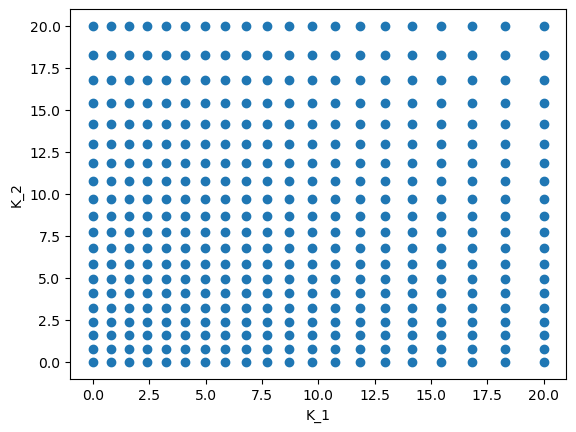

In [3]:
fig, ax = plt.subplots()
k1_mesh,k2_mesh = np.meshgrid(par.k_grid,par.k_grid,indexing='ij')
ax.scatter(k1_mesh,k2_mesh)
ax.set(xlabel='K_1',ylabel='K_2');

**Tax function:**

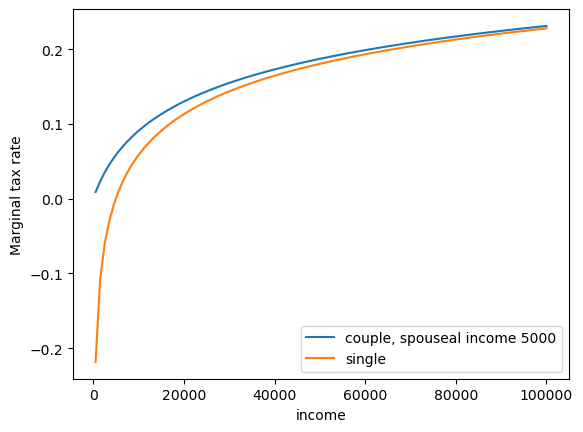

In [4]:
income_grid = np.linspace(500,100_000,100)
tax_grid = np.nan + np.ones(income_grid.shape)
tax_grid_s = np.nan + np.ones(income_grid.shape)
for i,income in enumerate(income_grid):
    tax_grid[i] = model.tax_func(income + 5000.0 +1.0) - model.tax_func(income + 5000.0)
    tax_grid_s[i] = model.tax_func(income +1.0) - model.tax_func(income)

fig, ax = plt.subplots()
ax.plot(income_grid,tax_grid)
ax.plot(income_grid,tax_grid_s)
ax.set(xlabel='income',ylabel="Marginal tax rate")
ax.legend(('couple, spouseal income 5000','single'));

## Solve the model

In [5]:
model.solve()

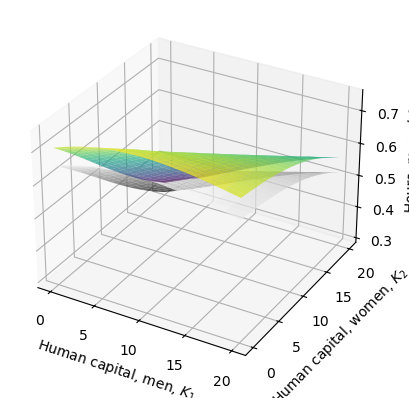

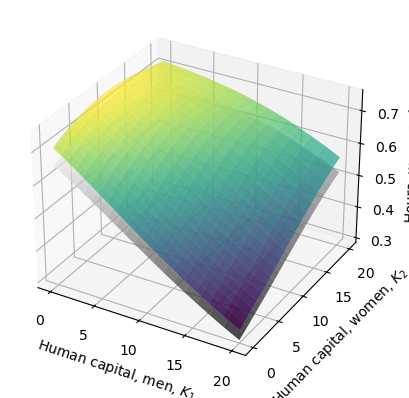

In [6]:
# first and last period hours
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(k1_mesh, k2_mesh, sol.h1[0],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.7);
ax.plot_surface(k1_mesh, k2_mesh, sol.h1[-1],rstride=1,cstride=1,cmap='gray', edgecolor='none',alpha=0.7);
ax.set(xlabel='Human capital, men, $K_1$',ylabel='Human capital, women, $K_2$',zlabel='Hours, men, $h_1^{\star}$');

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(k1_mesh, k2_mesh, sol.h2[0],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.7);
ax.plot_surface(k1_mesh, k2_mesh, sol.h2[-1],rstride=1,cstride=1,cmap='gray', edgecolor='none',alpha=0.7);
ax.set(xlabel='Human capital, men, $K_1$',ylabel='Human capital, women, $K_2$',zlabel='Hours, women, $h_2^{\star}$');

## In-class exercise

1. Look at the code and talk about it with the person next to you for 5 minutes
2. Write at least one question

# Simulation

With the solution at hand we can now simulate `simN` synthetic individuals for `simT` periods. We do so by initializing all state-variables in the first period and simulate forwards. 

Initial human capital of both members are the state variables in our model, and we start by initilizing all individuals with no human capital `sim.k1_init=np.zeros(par.simN)` and  `sim.k2_init=np.zeros(par.simN)`. <br>

We then loop forward using the solution:
$$
\begin{align}
h_{1,i,t} &= h_{1,t}^{\star}(k_{1,i,t},k_{2,i,t}) \\
h_{2,i,t} &= h_{2,t}^{\star}(k_{1,i,t},k_{2,i,t}) \\
k_{1,i,t+1} &= (1-\delta)k_{1,i,t} + h_{1,i,t}\\
k_{2,i,t+1} &= (1-\delta)k_{2,i,t} + h_{2,i,t}\\
\end{align}
$$


In [7]:
sim.k1_init = 2.0*np.ones(par.simN)
model.simulate()

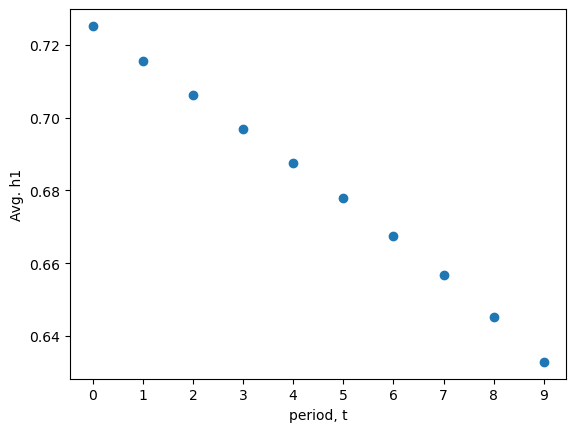

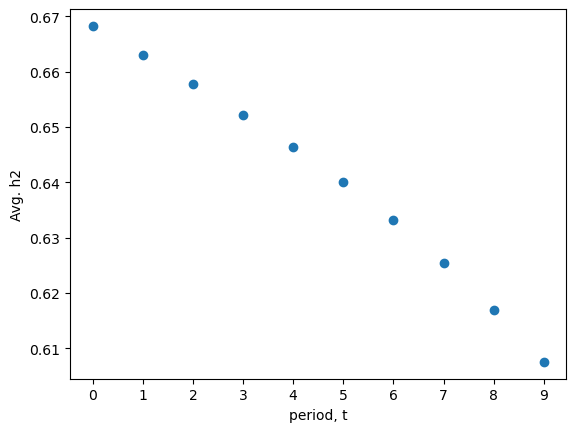

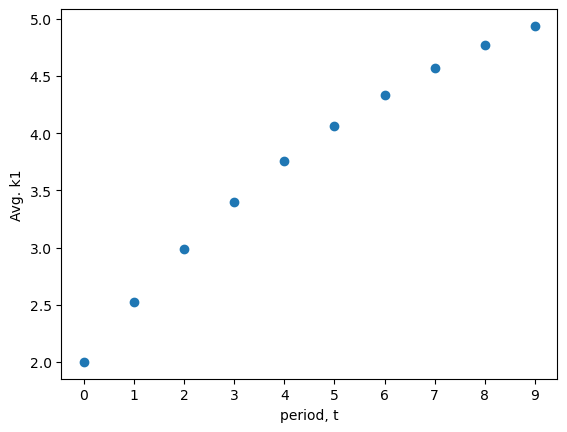

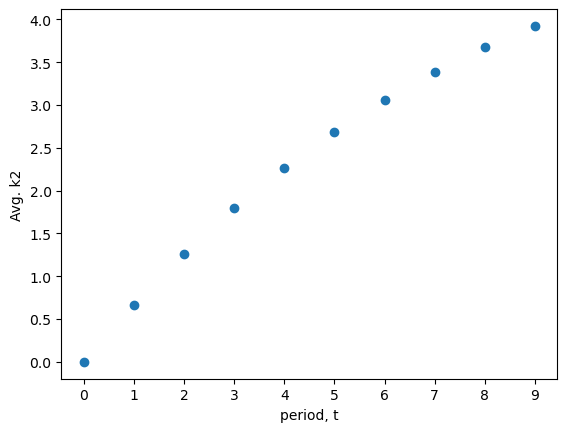

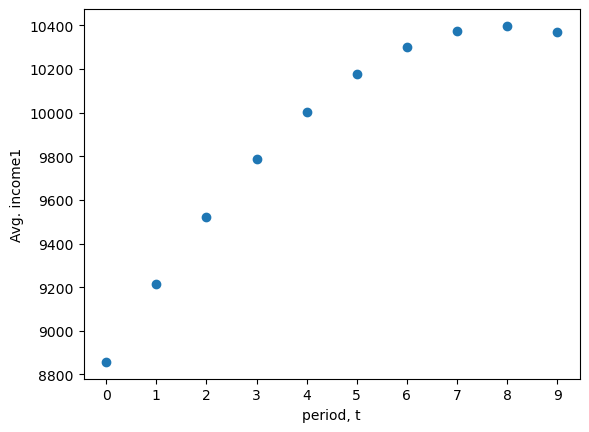

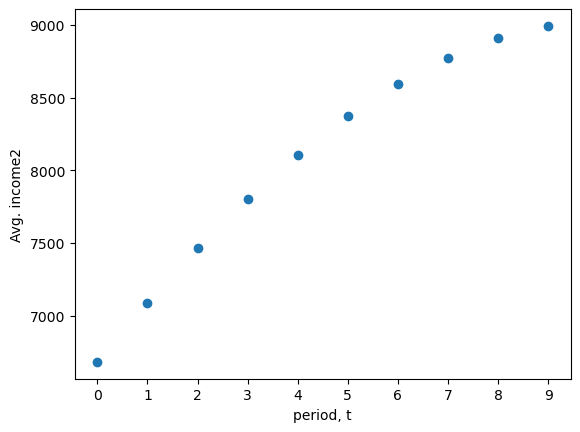

In [8]:
# plot behavior
for var in ('h1','h2','k1','k2','income1','income2'):
    fig, ax = plt.subplots()
    ax.scatter(range(par.simT),np.mean(getattr(sim,var),axis=0),label='Simulated')
    ax.set(xlabel='period, t',ylabel=f'Avg. {var}',xticks=range(par.simT));

## In-class exercise

1. Look at the code and talk about it with the person next to you for 5 minutes
2. Write at least one question

## Marshall Elasticities

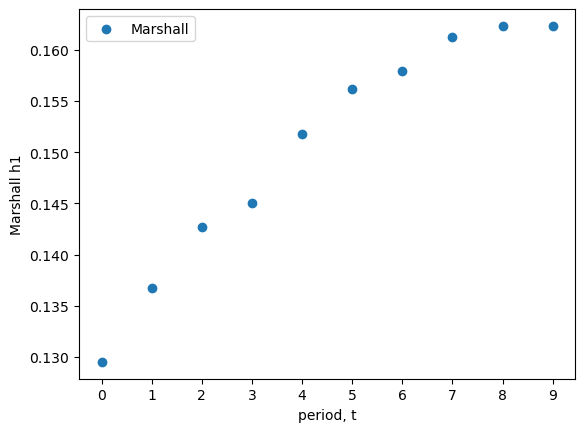

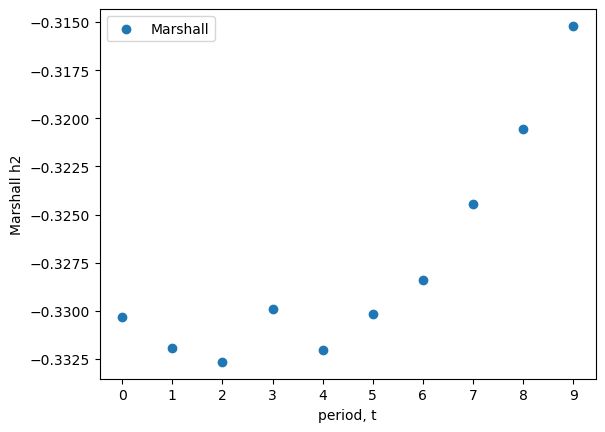

In [9]:
# increase wages of member 1 permanently from beginning (regime shift)
model_1 = model.copy()
model_1.par.wage_const_1 = np.log(np.exp(par.wage_const_1) * 1.01) # 1% increase in wage

model_1.solve()
model_1.simulate()

# plot elasticities
for var in ('h1','h2'):
    fig, ax = plt.subplots()
    base = np.mean(getattr(model.sim,var),axis=0)
    new = np.mean(getattr(model_1.sim,var),axis=0)
    ela = (new - base)/base*100
    ax.scatter(range(par.simT),ela,label='Marshall')
    ax.set(xlabel='period, t',ylabel=f'Marshall {var}',xticks=range(par.simT));
    ax.legend();

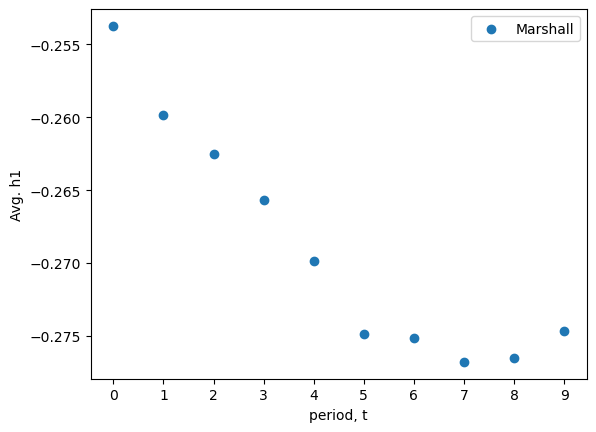

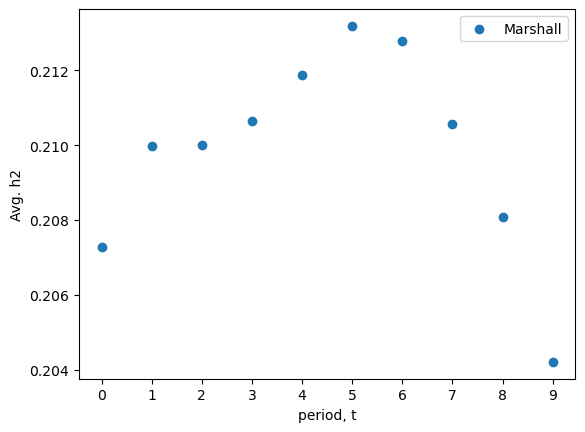

In [10]:
# increase wages of member 2 permanently 
model_2 = model.copy()
model_2.par.wage_const_2 = np.log(np.exp(par.wage_const_2) * 1.01) # 1% increase in wage

model_2.solve()
model_2.simulate()

# plot elasticities
for var in ('h1','h2'):
    fig, ax = plt.subplots()
    base = np.mean(getattr(model.sim,var),axis=0)
    new = np.mean(getattr(model_2.sim,var),axis=0)
    ela = (new - base)/base*100
    ax.scatter(range(par.simT),ela,label='Marshall')
    ax.set(xlabel='period, t',ylabel=f'Avg. {var}',xticks=range(par.simT));
    ax.legend();

# Policy Reform: move to individual taxation
This means that the household budget is now
$$
c_{t}  =\sum_{j=1}^{2}w_{j,t}h_{j,t}-T(w_{1,t}h_{1,t})-T(w_{2,t}h_{2,t})\\
$$

This can be implemented via the switch `par.joint_tax=False`.

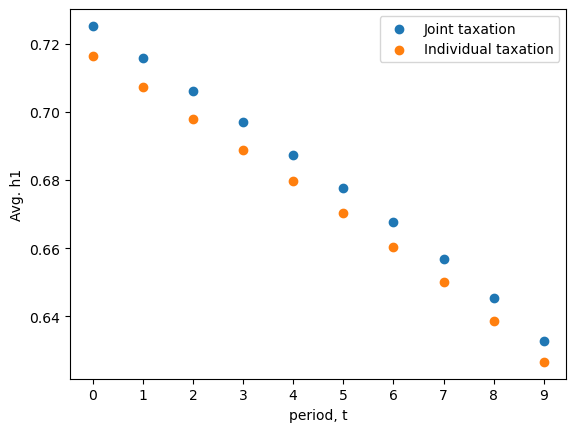

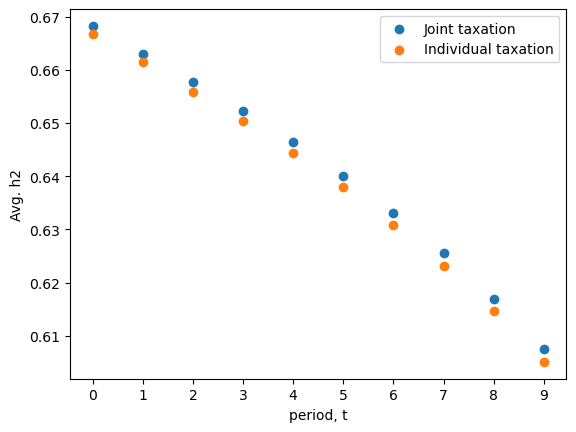

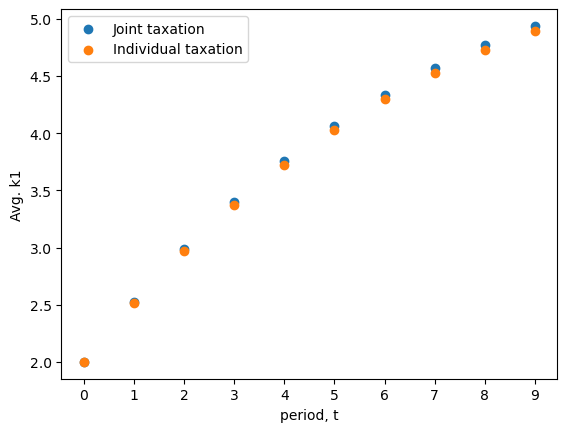

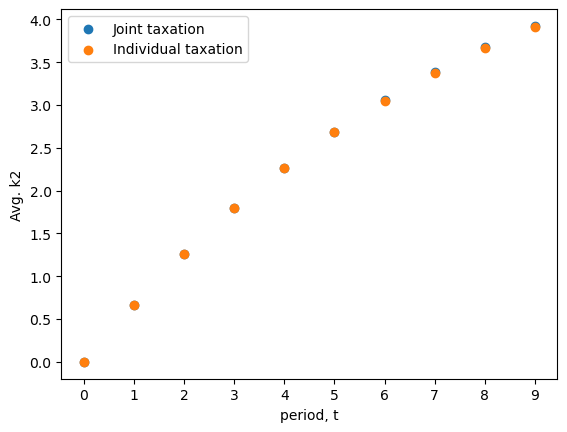

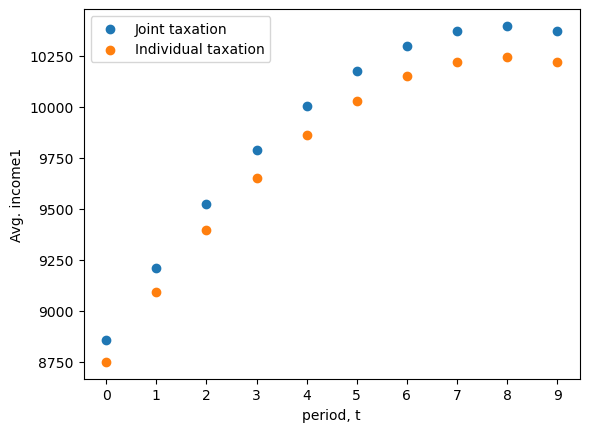

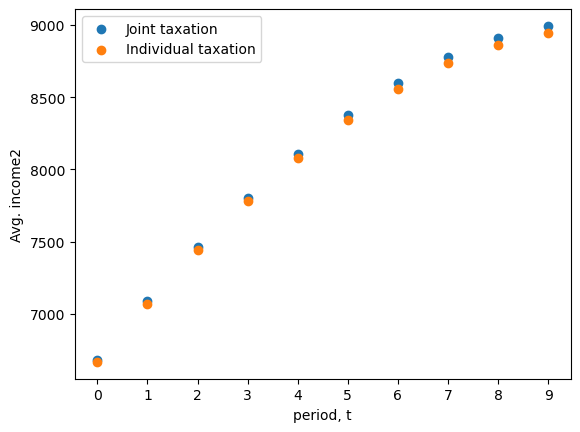

In [11]:
# NOTE: their change also involves changing the parameters of the tax-function!

model_indiv = DynHouseholdLaborModelClass(par={'joint_tax':False,}) 
model_indiv.solve()

model_indiv.sim.k1_init = 2.0*np.ones(par.simN)
model_indiv.simulate()

# plot behavior
for var in ('h1','h2','k1','k2','income1','income2'):
    fig, ax = plt.subplots()
    ax.scatter(range(par.simT),np.mean(getattr(model.sim,var),axis=0),label='Joint taxation')
    ax.scatter(range(par.simT),np.mean(getattr(model_indiv.sim,var),axis=0),label='Individual taxation')
    ax.set(xlabel='period, t',ylabel=f'Avg. {var}',xticks=range(par.simT));
    ax.legend();